# O2O用户优惠券使用预测

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from datetime import date
import matplotlib.pyplot as plt

%matplotlib inline

# 数据读取并查看

In [31]:
data = pd.read_csv(r'F:\pythoncode\Hands on machine learning\Hands on machine learning\ML-project\O2O优惠券使用预测\ccf_offline_stage1_train.csv',
                            dtype={'Coupon_id':str,'Distance':str,'Date_received':str,'Date':str})

In [34]:
data.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0,NaN,20160217
1,1439408,4663,11002,150:20,1,20160528,NaN
2,1439408,2632,8591,20:1,0,20160217,NaN
3,1439408,2632,1078,20:1,0,20160319,NaN
4,1439408,2632,8591,20:1,0,20160613,NaN


#User_id：用户ID；   Merchant_id：商户ID；
#Coupon_id：优惠券ID，null表示无优惠券消费，此时Discount_rate和Date_received字段无意义；
#Discount_rate：优惠率：x \in [0,1]代表折扣率；x:y表示满x减y。单位是元；
#Distance：user经常活动的地点离该merchant的最近门店距离是x*500米（如果是连锁店，则取最近的一家门店），x\in[0,10]；null表示无此信息，0表示低于500米，10表示大于5公里；
#Date_received：领取优惠券日期
#Date：消费日期：如果Date=null & Coupon_id != null，该记录表示领取优惠券但没有使用，即负样本；如果Date!=null & Coupon_id = null，则表示普通消费日期；如果Date!=null & Coupon_id != null，则表示用优惠券消费日期，即正样本

In [36]:
print('数据总条数：{}'.format(data.shape[0]))
print('有优惠券，消费：{}'.format(data.loc[(data['Coupon_id'].isnull().values == False)&(data['Date'].isnull().values == False)].shape[0]))
print('无优惠券，消费：{}'.format(data.loc[(data['Coupon_id'].isnull().values == True)&(data['Date'].isnull().values == False)].shape[0]))
print('有优惠券，无消费：{}'.format(data.loc[(data['Coupon_id'].isnull().values == False)&(data['Date'].isnull().values == True)].shape[0]))
print('无优惠券，无消费：{}'.format(data.loc[(offline_train['Coupon_id'].isnull().values == True)&(data['Date'].isnull().values == True)].shape[0]))

数据总条数：1754884
有优惠券，消费：75382
无优惠券，消费：701602
有优惠券，无消费：977900
无优惠券，无消费：0


使用优惠券进行消费的仅有75382条，大部分消费者收到优惠券后并不用优惠券消费（977900条），核销率较低。

# 数据预处理

1、转换优惠券折扣率：将满xx减yy类型(xx:yy)的券变成折扣率 : 1 - yy/xx，同时建立折扣券相关的特征 discount_rate, discount_man, discount_jian, discount_type；
2、将距离中的缺失值"nan"转换为-1

In [37]:
print('Discount_rate 类型：',data['Discount_rate'].unique())

Discount_rate 类型： [nan '150:20' '20:1' '200:20' '30:5' '50:10' '10:5' '100:10' '200:30'
 '20:5' '30:10' '50:5' '150:10' '100:30' '200:50' '100:50' '300:30'
 '50:20' '0.9' '10:1' '30:1' '0.95' '100:5' '5:1' '100:20' '0.8' '50:1'
 '200:10' '300:20' '100:1' '150:30' '300:50' '20:10' '0.85' '0.6' '150:50'
 '0.75' '0.5' '200:5' '0.7' '30:20' '300:10' '0.2' '50:30' '200:100'
 '150:5']


In [38]:
def get_discount_type(s):
    s = str(s)
    if s == 'nan':
        return None
    elif ':' in s:
        return 1
    else:
        return 0

def convert_rate(s):
    s = str(s)
    if s == 'nan':
        return 1.0
    elif ':' in s:
        s = s.split(':')
        return 1.0 - float(s[1])/float(s[0])
    else:
        return float(s)

def get_discount_man(s):
   s = str(s)
   if ':' in s:
       s = s.split(':')
       return int(s[0])
   else:
       return 0

def get_discount_jian(s):
    s = str(s)
    if ':' in s:
        s = s.split(':')
        return int(s[1])
    else:
        return 0

def processdata(df):

    df['discount_rate'] = df['Discount_rate'].apply(convert_rate)
    df['discount_man'] = df['Discount_rate'].apply(get_discount_man)
    df['discount_jian'] = df['Discount_rate'].apply(get_discount_jian)
    df['discount_type'] = df['Discount_rate'].apply(get_discount_type)

    df['distance'] = df['Distance'].astype(str).replace('nan',-1).astype(int)
    return df

data = processdata(data)

data.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,discount_type,distance
0,1439408,2632,NaN,NaN,0,NaN,20160217,1.000000,0,0,NaN,0
1,1439408,4663,11002,150:20,1,20160528,NaN,0.866667,150,20,1.0,1
2,1439408,2632,8591,20:1,0,20160217,NaN,0.950000,20,1,1.0,0
3,1439408,2632,1078,20:1,0,20160319,NaN,0.950000,20,1,1.0,0
4,1439408,2632,8591,20:1,0,20160613,NaN,0.950000,20,1,1.0,0


In [39]:
print(data['distance'].unique())

[ 0  1 -1  2 10  4  7  9  3  5  6  8]


3、优惠券日期处理

In [40]:
# 优惠券收到日期和消费日期
date_received = data['Date_received'].unique()
date_received = sorted(date_received[date_received.astype(str) != 'nan'].astype(int))

date_buy = data['Date'].unique()
date_buy = sorted(date_buy[date_buy.astype(str) != 'nan'].astype(int))

print('优惠券收到日期：',date_received[0],'到',date_received[-1])
print('用户消费日期：',date_buy[0],'到',date_buy[-1])

优惠券收到日期： 20160101 到 20160615
用户消费日期： 20160101 到 20160630


In [41]:
# 新建关于星期的特征'weekday'
def getweekday(s):
    s = str(s)
    if s == 'nan':
        return None
    else:
        return date(int(s[0:4]),int(s[4:6]),int(s[6:8])).weekday() + 1

data['weekday'] = data['Date_received'].apply(getweekday)

In [42]:
# 新建特征'weekday_type' : 周六和周日为1，其他为0
data['weekday_type'] = data['weekday'].apply(lambda x : 1 if x in [6,7] else 0)

In [43]:
print(data['weekday'].unique())

[nan  6.  3.  1.  5.  4.  7.  2.]


In [44]:
# 将特征'weekday'进行独热编码
data['weekday'] = data['weekday'].astype(str)
data = pd.get_dummies(data,columns=['weekday'])
data = data.drop(columns=['weekday_nan'])

4、数据标注：没有领取优惠券：y=-1，领取优惠券且15天内消费：y=1，其它：y=0

In [45]:
def label(s):
    if str(s['Date_received']) == 'nan':
        return -1
    elif str(s['Date']) != 'nan':
        td = pd.to_datetime(s['Date'],format='%Y%m%d') - pd.to_datetime(s['Date_received'],format='%Y%m%d')
        if td <= pd.Timedelta(15,'D'):
            return 1
        else:
            return 0
    else:
        return 0
data['label'] = data.apply(label,axis=1)

In [46]:
data['label'].value_counts()

 0    988887
-1    701602
 1     64395
Name: label, dtype: int64

# 特征提取

In [55]:
def userFeature(fdf):
    # 用户 User 特征
    u = fdf[['User_id']].drop_duplicates()

    # 每个用户领取的优惠券数量
    u1 = fdf[fdf['Date_received'].isnull().values == False][['User_id']]
    u1['u_coupon_count'] = 1
    u1 = u1.groupby(['User_id'], as_index=False).count()

    # 用户线下购买次数
    u2 = fdf[fdf['Date'].isnull().values == False][['User_id']]
    u2['u_buy_count'] = 1
    u2 = u2.groupby(['User_id'], as_index=False).count()

    # 用户线下使用优惠券购买次数
    u3 = fdf[((fdf['Date'].isnull().values == False) & (fdf['Date_received'].isnull().values == False))][['User_id']]
    u3['u_buy_with_coupon'] = 1
    u3 = u3.groupby(['User_id'], as_index=False).count()

    # 用户购买过商家数量
    u4 = fdf[fdf['Date'].isnull().values == False][['User_id', 'Merchant_id']]
    u4.drop_duplicates(inplace=True)
    u4 = u4.groupby(['User_id'], as_index=False).count()
    u4.rename(columns={'Merchant_id': 'u_merchant_count'}, inplace=True)

    # u_min_distance
    utmp = fdf[((fdf['Date'].isnull().values == False)) & (fdf['Date_received'].isnull().values == False)][
        ['User_id', 'distance']]
    utmp.replace(-1, np.nan, inplace=True)
    u5 = utmp.groupby(['User_id'], as_index=False).min()
    u5.rename(columns={'distance': 'u_min_distance'}, inplace=True)
    u6 = utmp.groupby(['User_id'], as_index=False).max()
    u6.rename(columns={'distance': 'u_max_distance'}, inplace=True)
    u7 = utmp.groupby(['User_id'], as_index=False).mean()
    u7.rename(columns={'distance': 'u_mean_distance'}, inplace=True)
    u8 = utmp.groupby(['User_id'], as_index=False).median()
    u8.rename(columns={'distance': 'u_median_distance'}, inplace=True)

    # 把所有用户特征整合
    user_feature = pd.merge(u, u1, on='User_id', how='left')
    user_feature = pd.merge(user_feature, u2, on='User_id', how='left')
    user_feature = pd.merge(user_feature, u3, on='User_id', how='left')
    user_feature = pd.merge(user_feature, u4, on='User_id', how='left')
    user_feature = pd.merge(user_feature, u5, on='User_id', how='left')
    user_feature = pd.merge(user_feature, u6, on='User_id', how='left')
    user_feature = pd.merge(user_feature, u7, on='User_id', how='left')
    user_feature = pd.merge(user_feature, u8, on='User_id', how='left')

    # 用户优惠券使用率
    user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'] / user_feature['u_coupon_count']
    user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'] / user_feature['u_buy_count']
    user_feature = user_feature.fillna(0)

    return user_feature


def merchantFeature(fdf):
    # 商家id
    m = fdf[['Merchant_id']].copy().drop_duplicates()

    # 商家发放的优惠券数量
    m1 = fdf[fdf['Date_received'].isnull().values == False][['Merchant_id']]
    m1['m_coupon_count'] = 1
    m1 = m1.groupby(['Merchant_id'], as_index=False).count()

    # 商家销售订单数（全部）
    m2 = fdf[fdf['Date'].isnull().values == False][['Merchant_id']]
    m2['m_sale_count'] = 1
    m2 = m2.groupby(['Merchant_id'], as_index=False).count()

    # 商家销售订单数（使用优惠券）
    m3 = fdf[(fdf['Date'].isnull().values == False) & (fdf['Date_received'].isnull().values == False)][['Merchant_id']]
    m3['m_sale_with_coupon'] = 1
    m3 = m3.groupby(['Merchant_id'], as_index=False).count()

    # m_min_distance
    mtmp = fdf[(fdf['Date'].isnull().values == False) & (fdf['Date_received'].isnull().values == False)][
        ['Merchant_id', 'distance']]
    mtmp.replace(-1, np.nan, inplace=True)
    m4 = mtmp.groupby(['Merchant_id'], as_index=False).min()
    m4.rename(columns={'distance': 'm_min_distance'}, inplace=True)
    m5 = mtmp.groupby(['Merchant_id'], as_index=False).max()
    m5.rename(columns={'distance': 'm_max_distance'}, inplace=True)
    m6 = mtmp.groupby(['Merchant_id'], as_index=False).mean()
    m6.rename(columns={'distance': 'm_mean_distance'}, inplace=True)
    m7 = mtmp.groupby(['Merchant_id'], as_index=False).median()
    m7.rename(columns={'distance': 'm_median_distance'}, inplace=True)


    # 整合商家特征
    merchant_feature = pd.merge(m, m1, on='Merchant_id', how='left')
    merchant_feature = pd.merge(merchant_feature, m2, on='Merchant_id', how='left')
    merchant_feature = pd.merge(merchant_feature, m3, on='Merchant_id', how='left')
    merchant_feature = pd.merge(merchant_feature, m4, on='Merchant_id', how='left')
    merchant_feature = pd.merge(merchant_feature, m5, on='Merchant_id', how='left')
    merchant_feature = pd.merge(merchant_feature, m6, on='Merchant_id', how='left')
    merchant_feature = pd.merge(merchant_feature, m7, on='Merchant_id', how='left')
    merchant_feature = merchant_feature.fillna(0)

    # 商家优惠券被使用率
    merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'] / merchant_feature['m_coupon_count']
    merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'] / merchant_feature[
        'm_sale_count']
    merchant_feature = merchant_feature.fillna(0)

    return merchant_feature


def usermerchantFeature(fdf):
    um = fdf[['User_id', 'Merchant_id']].copy().drop_duplicates()
    um1 = fdf[['User_id', 'Merchant_id']].copy()
    um1['um_count'] = 1
    um1 = um1.groupby(['User_id', 'Merchant_id'], as_index=False).count()

    um2 = fdf[fdf['Date'].isnull().values == False][['User_id', 'Merchant_id']].copy()
    um2['um_buy_count'] = 1
    um2 = um2.groupby(['User_id', 'Merchant_id'], as_index=False).count()

    um3 = fdf[fdf['Date_received'].isnull().values == False][['User_id', 'Merchant_id']].copy()
    um3['um_coupon_count'] = 1
    um3 = um3.groupby(['User_id', 'Merchant_id'], as_index=False).count()

    um4 = fdf[(fdf['Date_received'].isnull().values == False) & (fdf['Date'].isnull().values == False)][
        ['User_id', 'Merchant_id']].copy()
    um4['um_buy_with_coupon'] = 1
    um4 = um4.groupby(['User_id', 'Merchant_id'], as_index=False).count()

    # 整合特征
    user_merchant_feature = pd.merge(um, um1, on=['User_id', 'Merchant_id'], how='left')
    user_merchant_feature = pd.merge(user_merchant_feature, um2, on=['User_id', 'Merchant_id'], how='left')
    user_merchant_feature = pd.merge(user_merchant_feature, um3, on=['User_id', 'Merchant_id'], how='left')
    user_merchant_feature = pd.merge(user_merchant_feature, um4, on=['User_id', 'Merchant_id'], how='left')
    user_merchant_feature = user_merchant_feature.fillna(0)

    user_merchant_feature['um_buy_rate'] = user_merchant_feature['um_buy_count'] / user_merchant_feature['um_count']
    user_merchant_feature['um_coupon_use_rate'] = user_merchant_feature['um_buy_with_coupon'] / user_merchant_feature[
        'um_coupon_count']
    user_merchant_feature['um_buy_with_coupon_rate'] = user_merchant_feature['um_buy_with_coupon'] / \
                                                       user_merchant_feature['um_buy_count']
    user_merchant_feature = user_merchant_feature.fillna(0)

    return user_merchant_feature

def featureProcess(feature,train):
    user_feature = userFeature(feature)
    merchant_feature = merchantFeature(feature)
    user_merchant_feature = usermerchantFeature(feature)

    train = pd.merge(train,user_feature,on = 'User_id',how = 'left')
    train = pd.merge(train,merchant_feature,on = 'Merchant_id',how = 'left')
    train = pd.merge(train,user_merchant_feature,on = ['User_id','Merchant_id'],how = 'left')
    train = train.fillna(0)

    return train

In [47]:
feature = data[(data['Date'] < '20160516') | ((data['Date'].isnull().values == True) & (data['Date_received'] < '20160516'))]
data = data[(data['Date_received'] >= '20160516') & (data['Date_received'] <= '20160615')]
print(data['label'].value_counts())

0    229715
1     22871
Name: label, dtype: int64


In [56]:
train = featureProcess(feature,data)

In [57]:
train.shape

(252586, 47)

In [58]:
print(train.columns.tolist())

['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Date_received', 'Date', 'discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance', 'weekday_type', 'weekday_1.0', 'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0', 'weekday_6.0', 'weekday_7.0', 'label', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']


In [60]:
predictors = ['discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance','weekday_type', 'weekday_1.0',
              'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0', 'weekday_6.0', 'weekday_7.0', 
              'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 
              'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 
              'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance',
              'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 
              'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']

# 模型训练

1、划分训练集与测试集

In [74]:
X = train[predictors]
y = train['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 0)

2、训练梯度提升决策树模型（GBDT）

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score

# 对迭代次数进行调参
param_grid = {'n_estimators':range(10,101,10)}
grid_search = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1,random_state = 0),param_grid,scoring='roc_auc',cv=5)
grid_search.fit(X_train,y_train)
print('best_params:{}'.format(grid_search.best_params_))
print('best_score:{:.3f}'.format(grid_search.best_score_))

best_params:{'n_estimators': 100}
best_score:0.839


精度:0.916
AUC:0.837


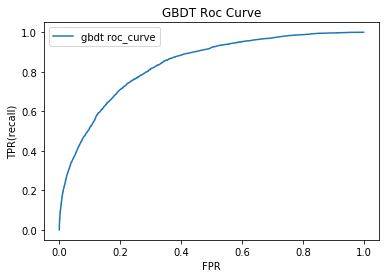

In [87]:
# 计算准确率和AUC
best_model = GradientBoostingClassifier(learning_rate=0.1,n_estimators = 100,random_state = 0)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
y_predprob = best_model.predict_proba(X_test)[:,1]
print('精度:{:.3f}'.format(accuracy_score(y_test,y_pred)))
print('AUC:{:.3f}'.format(roc_auc_score(y_test,y_predprob)))

# 绘制ROC曲线
from sklearn.metrics import roc_curve

FPR,TPR,thresholds = roc_curve(y_test,y_predprob)
plt.plot(FPR,TPR,label='gbdt roc_curve')
plt.title('GBDT Roc Curve')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
plt.legend(loc='best')